<a href="https://colab.research.google.com/github/haripy123/GANs/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.transforms import v2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,ConcatDataset
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import os
from torchsummary import summary
from torch import optim
from torchvision import datasets

In [ ]:
transforms=v2.Compose([v2.PILToTensor(),v2.ToDtype(torch.float,scale=True)])
ds_train=datasets.CIFAR10(root='data',transform=transforms,download=True)
ds_test=datasets.CIFAR10(root='data',train=False,transform=transforms,download=True)
ds=ConcatDataset([ds_train,ds_test])

In [3]:
epochs=20
batch=64
lr=1e-4
beta1=0.5
beta2=0.999
lamb=10
n_critic=5
num_classes,embed_size=10,100
dim,n_channels,img_size=100,3,32
dataloader=DataLoader(ds,shuffle=True,batch_size=batch,drop_last=True)

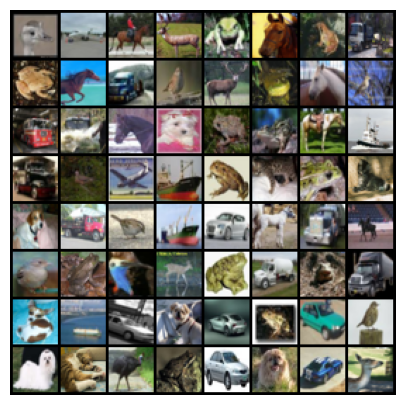

In [4]:
x=next(iter(dataloader))
grid=make_grid(x[0])
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1,2,0).clamp(0.,1.))
plt.axis('off')
plt.show()

In [37]:
labels_dict={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [6]:
class Generator(nn.Module):
    def __init__(self,dim,n_channels,img_size,num_classes,embed_size):
        super().__init__()
        self.net=nn.Sequential(
            nn.ConvTranspose2d(dim+embed_size,img_size*4,4,1,0,bias=False),
            nn.BatchNorm2d(img_size*4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size*4,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size*2,img_size,4,2,1,bias=False),
            nn.BatchNorm2d(img_size),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(img_size,n_channels,4,2,1,bias=False),
            nn.Tanh(),
        )
        self.embedding=nn.Embedding(num_classes,embed_size)
    def forward(self,x,labels):
        emb=self.embedding(labels).unsqueeze(2).unsqueeze(3)
        x=torch.cat([x,emb],dim=1)
        return self.net(x)

In [7]:
class Critic(nn.Module):
    def __init__(self,n_channels,img_size,num_classes):
        super().__init__()
        self.img_size=img_size
        self.num_classes=num_classes
        self.net=nn.Sequential(
            nn.Conv2d(n_channels+1,img_size,4,2,1,bias=False),
            nn.LayerNorm((img_size,img_size//2,img_size//2)),
            nn.LeakyReLU(),
            nn.Conv2d(img_size,img_size*2,4,2,1,bias=False),
            nn.LayerNorm((img_size*2,img_size//4,img_size//4)),
            nn.LeakyReLU(),
            nn.Conv2d(img_size*2,img_size*4,4,2,1,bias=False),
            nn.LayerNorm((img_size*4,img_size//8,img_size//8)),
            nn.LeakyReLU(),
            nn.Conv2d(img_size*4,1,4,1,0,bias=False),
        )
        self.embedding=nn.Embedding(num_classes,self.img_size*self.img_size)
    def forward(self,x,labels):
        emb=self.embedding(labels).reshape(labels.shape[0],1,self.img_size,self.img_size)
        x=torch.cat([x,emb],dim=1)
        return self.net(x)

In [8]:
def weight_init(mod):
    name=mod.__class__.__name__
    if 'Conv' in name:
        nn.init.normal_(mod.weight.data,0.,0.02)
    elif 'BatchNorm' in name:
        nn.init.normal_(mod.weight.data,1.,0.02)
        nn.init.constant_(mod.bias.data,0.)

In [10]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
gen=Generator(dim,n_channels,img_size,num_classes,embed_size).to(device)
critic=Critic(n_channels,img_size,num_classes).to(device)
gen.apply(weight_init)
critic.apply(weight_init)

Critic(
  (net): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LayerNorm((32, 16, 16), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LayerNorm((64, 8, 8), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LayerNorm((128, 4, 4), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (embedding): Embedding(10, 1024)
)

In [27]:
c_optim=optim.Adam(critic.parameters(),lr=lr,betas=(beta1,beta2))
g_optim=optim.Adam(gen.parameters(),lr=lr,betas=(beta1,beta2))

In [28]:
def gradient_penalty(real,fake,labels,critic,device='cpu'):
  batch=real.shape[0]
  epsilon=torch.rand(batch,1,1,1).to(device)
  interpolated_imgs=epsilon*real+(1-epsilon)*fake
  interpolated_imgs.requires_grad_(True)
  i_pred=critic(interpolated_imgs,labels).reshape(-1)
  gradients=torch.autograd.grad(inputs=interpolated_imgs,
                                outputs=i_pred,
                                grad_outputs=torch.ones_like(i_pred),
                                create_graph=True,
                                retain_graph=True)[0]
  grads=gradients.reshape(batch,-1)
  grads_norm=grads.norm(2,dim=1)
  g_penalty=grads_norm.sub(1).pow(2).mean()
  return g_penalty

In [ ]:
print('Training......')
new_imgs=[]
c_l=[]
g_l=[]
for epoch in range(epochs):
  gen.train()
  critic.train()
  for idx,(imgs,labels) in enumerate(dataloader):
    input=imgs.to(device)
    labels=labels.to(device)
    for c in range(n_critic):
      critic.zero_grad()
      noise=torch.randn(batch,dim,1,1,device=device)
      fake=gen(noise,labels)
      loss_real=critic(input,labels).reshape(-1)
      loss_fake=critic(fake.detach(),labels).reshape(-1)
      loss_c=loss_fake.mean()-loss_real.mean()+lamb*gradient_penalty(input,fake.detach(),labels,critic,device=device)
      loss_c.backward()
      c_optim.step()
    gen.zero_grad()
    g_pred=critic(fake,labels).reshape(-1)
    loss_gen=-(g_pred.mean())
    loss_gen.backward()
    g_optim.step()
    c_l.append(loss_c.item())
    g_l.append(loss_gen.item())
  print(f'***epoch:{epoch},  critic_loss:{loss_c.item()} ,  gen_loss:{loss_gen.item()}***')
  if (epoch+1)%10==0:
    with torch.no_grad():
      n_noise=torch.randn(batch,dim,1,1,device=device)
      labels=torch.randint(0,10,(batch,)).to(device)
      n_imgs=gen(n_noise,labels)
      new_imgs.append(make_grid(n_imgs.detach().cpu(),normalize=True))

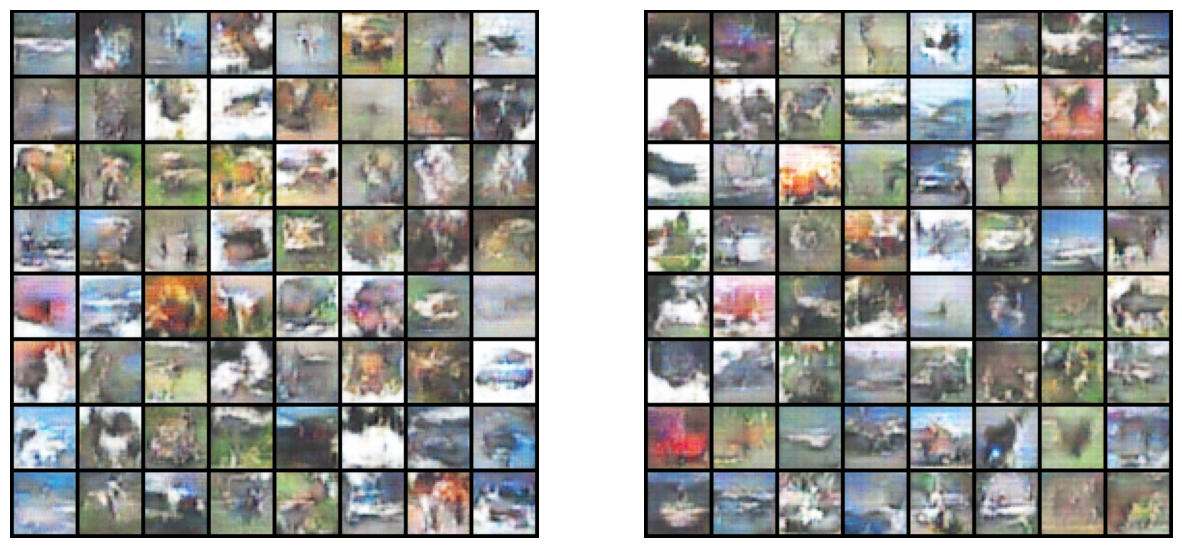

In [35]:
plt.figure(figsize=(15,7))
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(new_imgs[i].permute(1,2,0))
  plt.axis('off')

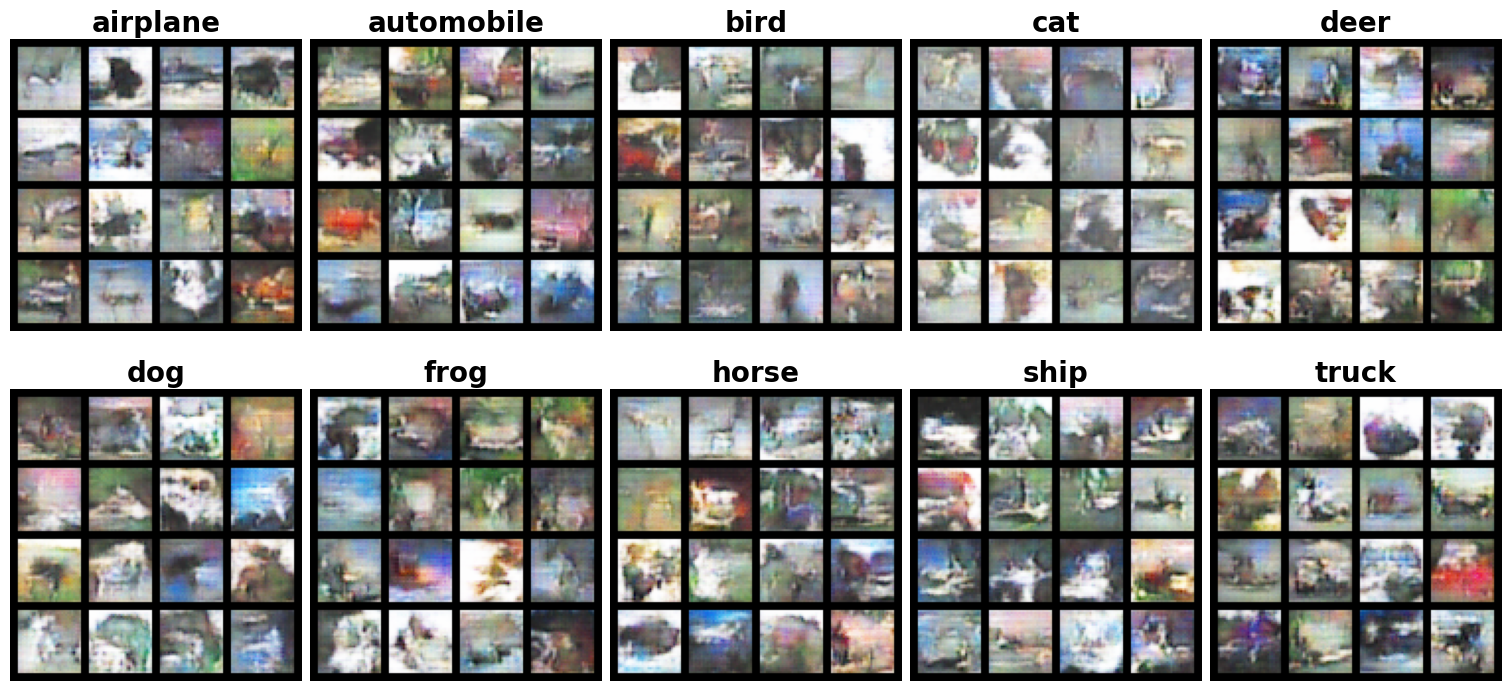

In [44]:
plt.figure(figsize=(15,7),layout='constrained')
for i in range(10):
  with torch.no_grad():
    l=torch.full((16,),i).to(device)
    n=torch.randn(16,dim,1,1).to(device)
    n_imgs=gen(n,l)
    grid=make_grid(n_imgs,4,4,normalize=True)
    plt.subplot(2,5,i+1)
    plt.imshow(grid.cpu().permute(1,2,0))
    plt.axis('off')
    plt.title(labels_dict[i],fontsize=20,fontweight='bold')